# Neural Style Transfer with 19-layer VGG-Network

**Goal**: Generate a new image G from a base image B with styles from a style image S.


## Defining the cost function

Minimize a cost function relating G, B and S w.r.t. G
$$J(G) = J(G; B, S)$$
where B and S are fixed. Further we assume the following form
$$J(G;B,S) = \alpha J(G; B) + \beta J(G; S)$$ 

In a ConvNet the shallow layers are activated by small image elements such as edges, whereas the deeper layers are activated by larger structures (see e.g. [Zeiler, Ferges (2013)](https://arxiv.org/abs/1311.2901)). Thus, styles are captured by the activation functions in the middle of ConvNets. 

In order to enforce similarity between B and G we use MSE as base cost for a deep layer $l$
$$J(G; B) = \frac{1}{2}\|a^{l}_B - a^l_G\|$$
where $a^l$ is the activation vector of layer $l$.

The filter channel activations correspond to the appearance of certain structures and style is composed of several structures. For this reason we want to use the correlation between the filters as a measure for the style cost. 

The gram matrix is well suited for this task, so we define the style cost as
$$J^l(G; S) \propto \sum_{k k'} \left( G_{kk'}^{lS} - G_{kk'}^{lG} \right)^2$$
where
$$G^l_{kk'} = \sum_{ij}^{n_W n_H} a^l_{ijk} a^l_{ijk'}$$

Collecting styles from different layers turned out to be more effective, therefore we define the full style cost as weighted sum of different layer style costs
$$J(G;S) = \sum_l J^l(G;S)$$

This completes our discussion on the form of the cost function and we turn to the realization.

In [1]:
import scipy.io
import imageio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow

## Loader 19-VGG model
Code from the MathConvNet team. The model can be downloaded [here](http://www.vlfeat.org/matconvnet/pretrained/).

In [0]:
def load_vgg_model(path, shape):
    """
    Detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, shape[0], shape[1], 3)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

## Helper functions

In [0]:
def save_image(path, image):
  image = image + MEANS
  image = np.clip(image[0], 0, 255).astype('uint8')
  imageio.imsave(path, image, format='png')

def show_image(image):
  image = image + MEANS
  image = np.clip(image[0], 0, 255).astype('uint8')
  imshow(image)

def noise_image(content_image, noise_ratio = 0.6):
  shape = content_image.shape    
  noise_image = np.random.uniform(-20, 20, shape).astype('float32')
  return noise_image * noise_ratio + content_image * (1 - noise_ratio)

def shape_input(image):
  image = np.reshape(image, ((1,) + image.shape))
  return image - MEANS

## Cost function

In [0]:
def gram(A):
  return tf.matmul(A, tf.transpose(A))

def content_cost(a_C, a_G):
  _, n_H, n_W, n_C = a_G.get_shape().as_list()
  
  a_C_flattened = tf.transpose(tf.reshape(a_C, [-1]))
  a_G_flattened = tf.transpose(tf.reshape(a_G, [-1]))

  return tf.reduce_sum(tf.square(tf.subtract(a_C_flattened,a_G_flattened))) / (4 * n_H * n_W * n_C)

def layer_style_cost(a_G, a_S):
  _, n_H, n_W, n_C = a_G.get_shape().as_list()
  
  a_S = tf.reshape(tf.transpose(a_S), [n_C, n_H*n_W])
  a_G = tf.reshape(tf.transpose(a_G), [n_C, n_H*n_W])

  G_G = gram(a_G)
  G_S = gram(a_S)

  return tf.reduce_sum(tf.square(tf.subtract(G_S,G_G)))/(2 * n_C * n_W * n_H)**2

def style_cost(model, style_layers):
  J_S = 0
  for layer, lambd in style_layers:
    out = model[layer]
    
    a_S = sess.run(out)
    a_G = out
        
    J_S_l = layer_style_cost(a_G, a_S)
    J_S += lambd * J_S_l

  return J_S

def total_cost(J_C, J_S, ratio = 0.001):
  return ratio*J_C + J_S

## Training

In [0]:
def train(sess, input_image, J, J_C, J_S, train_step, num_iterations = 1000):
    sess.run(tf.global_variables_initializer())

    sess.run(model["input"].assign(input_image))

    for step in range(num_iterations):
        sess.run(train_step)
        img_G = sess.run(model['input'])

        if step%20 == 0:
            Jt, Jc, Js = sess.run([J, J_C, J_S])
            print("Iteration " + str(step) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            print("Print image... ")
            save_image(PATH + "output/" + str(step) + ".png", img_G)
            print("Done!")

    save_image(path + 'output/final.jpg', img_G)

## Initialization

In [6]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks/NST/images/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
PATH = '/content/drive/My Drive/Colab Notebooks/NST/'
COSTRATIO = 1e-3
NOISERATIO = 0.6
STYLE_LAYERS = [
    ('conv1_1', 0.25),
    ('conv2_1', 0.25),
    ('conv3_1', 0.25),
    ('conv4_1', 0.25)]#,
    #('conv5_1', 0.2)]

## Load Data
+ Style: [link](https://unsplash.com/photos/blodpR3hVZE)
+ Content: [link](https://de.wikipedia.org/wiki/U-Bahnhof_Bahnhof_Deutz/Messe)

In [8]:
img_S = imageio.imread(PATH + 'images/steve-johnson-green.jpg')
img_C = imageio.imread(PATH + 'images/kvb-wiki.jpg')
input_shape = img_S.shape[0:2]

print("Content image shape: \t" + str(img_C.shape))
print("Style image shape: \t" + str(img_S.shape))
print("Input shape: \t\t" + str(input_shape))

Content image shape: 	(565, 800, 3)
Style image shape: 	(565, 800, 3)
Input shape: 		(565, 800)


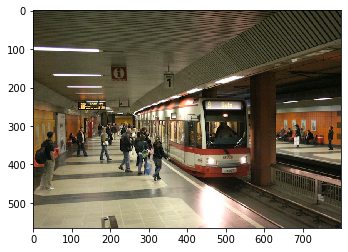

In [9]:
imshow(img_C);

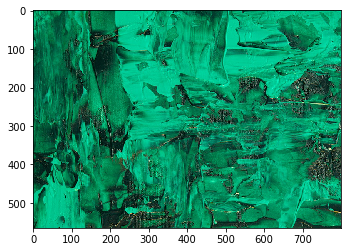

In [10]:
imshow(img_S);

## Shape input and generate noisy image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Content image shape: 	(1, 565, 800, 3)
Style image shape: 	(1, 565, 800, 3)
Generated image shape: 	(1, 565, 800, 3)


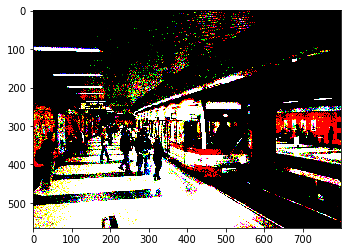

In [11]:
img_S = shape_input(img_S)
img_C = shape_input(img_C)

img_G = noise_image(img_C, NOISERATIO)

print("Content image shape: \t" + str(img_C.shape))
print("Style image shape: \t" + str(img_S.shape))
print("Generated image shape: \t" + str(img_G.shape))

imshow(img_G[0]);

## Load model and compute cost

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = load_vgg_model(PATH + 'pretrained-model/imagenet-vgg-verydeep-19.mat', input_shape)

sess.run(model['input'].assign(img_C))

out = model['conv4_2']
a_C = sess.run(out)
a_G = out

J_C = content_cost(a_C, a_G)

sess.run(model['input'].assign(img_S))

J_S = style_cost(model, STYLE_LAYERS)
J = total_cost(J_C, J_S, COSTRATIO)

train_step = tf.train.AdamOptimizer(2.0).minimize(J)

## Training

In [0]:
train(sess, img_G, J, J_C, J_S, train_step, num_iterations = 1000)

Iteration 0 :
total cost = 655552600.0
content cost = 7372.5464
style cost = 655552600.0
Print image... 
Done!
